# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

Here, we are determining the thermal stability of about a hundred and fifty point mutants of BglB (model based on 2JIE). After automated mutagensis of the BglB coding sequence, protein production, and protein purification, each mutant's activity at 100 mM pNPG at pH 7.4 at a range of temperatures from 30 C to 50 C was measured using the rate of formation of the pNPG hydrolysis product p-nitrophenol. 

Data were collected into a table with the columns `well`, `rate`, and `mutant` using Google Docs and exported to CSV, which is the input file here. 

## Data input and cleanup 

In [266]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/Bagel Thermostability - Thermostability assay data.csv' )
raw = len( df )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

with open( 'data/allowed_mutants.txt' ) as fn:
    mutants = [ i.split('.')[0].upper() for i in fn.readlines() if len( i ) > 1 ]
    
def is_good( name ):
    return name in mutants 

# this is a sanity-checking routine for "off-by-threes"
# let's just rename all the tubes
not_allowed = []
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            not_allowed.append( name )
            
assert len( df.index ) == len( l ) # do not want to reindex wrongly! 
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )
pos_and_neg = len( df )
df = df[( df.rate > 0 )]
df.sample( 10 )

# diagnostics 
print 'Input has {} rates. {} will be used, {} will be dropped because of mutant name, {} because negative).'.format( raw, len( df ), raw - pos_and_neg , pos_and_neg - len( df ) ), 
print 'Samples {} were dropped because the given native residue does not match the BglB sequence and is not off by three'.format( set( not_allowed ) )

Input has 3048 rates. 2276 will be used, 120 will be dropped because of mutant name, 652 because negative). Samples set(['E17S', 'E53A', 'Q384R', 'W299A']) were dropped because the given native residue does not match the BglB sequence and is not off by three


## Determine protein parameters Tm and k

To determine protein parameters Tm and k (steepness of melting curve), we will fit the cleaned data to the logistic equation. To determine starting parameters for the search algorithm `curve_fit`, we'll just fit a straight line to the data using SciKit-Learn's linear regression. 

In [267]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn using approximate params from linear fit
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) 
        if 30 < popt[0] < 50 and popt[1] < 0: # biological assay limits, and make sure k is the right sign
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits.dropna() ), len( grouped ) )

Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.

Successfully fit 87 of 120 samples to the logistic equation


In [268]:
fits

,tm,k
mutant,,
A195S,39.082601,-0.906304
A356A,39.888266,-1.124698
A357A,39.094581,-0.325209
A408A,39.955931,-1.260729
C167A,39.735604,-1.388447
C167Q,38.471567,-0.529354
D403A,NaN,NaN
E154D,38.699104,-0.688686
E164A,NaN,NaN


## Diagnostic plots to help determine goodness of fits

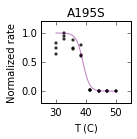

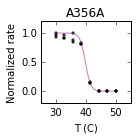

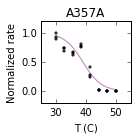

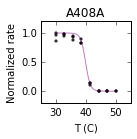

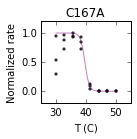

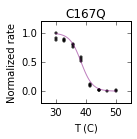

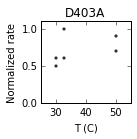

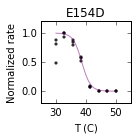

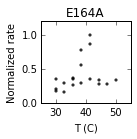

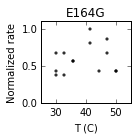

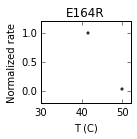

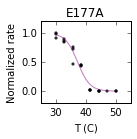

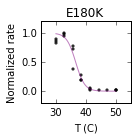

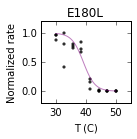

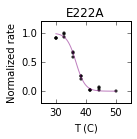

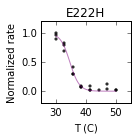

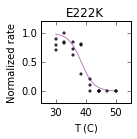

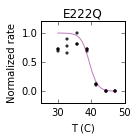

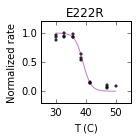

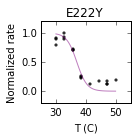

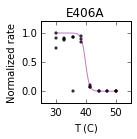

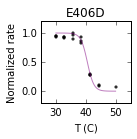

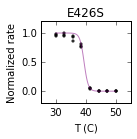

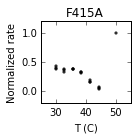

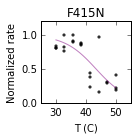

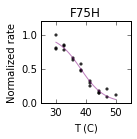

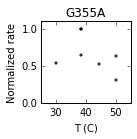

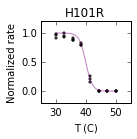

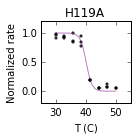

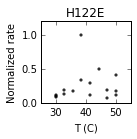

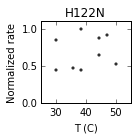

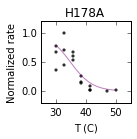

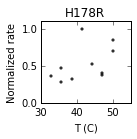

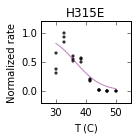

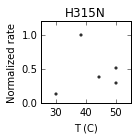

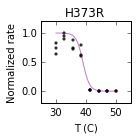

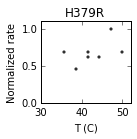

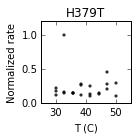

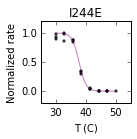

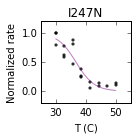

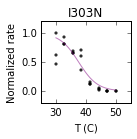

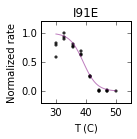

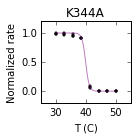

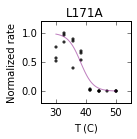

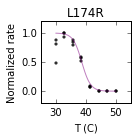

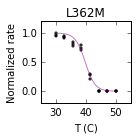

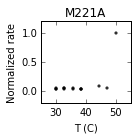

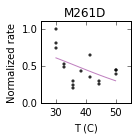

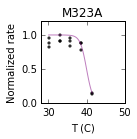

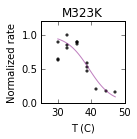

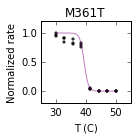

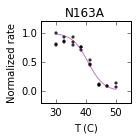

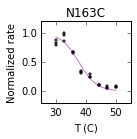

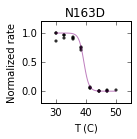

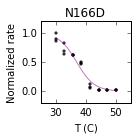

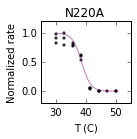

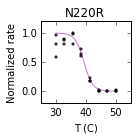

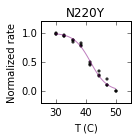

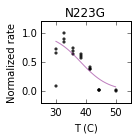

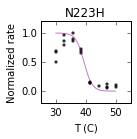

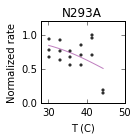

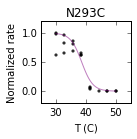

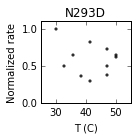

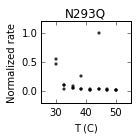

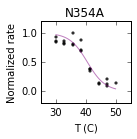

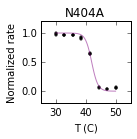

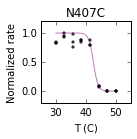

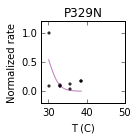

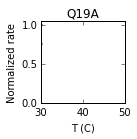

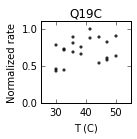

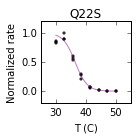

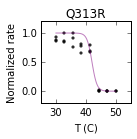

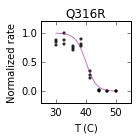

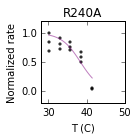

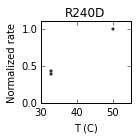

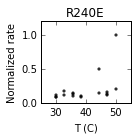

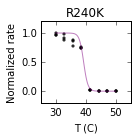

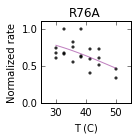

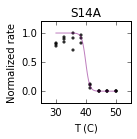

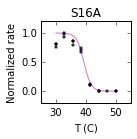

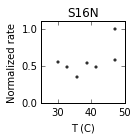

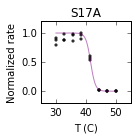

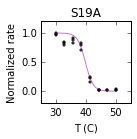

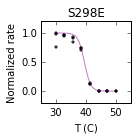

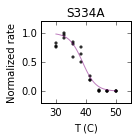

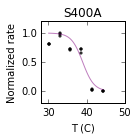

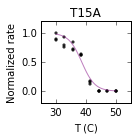

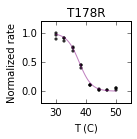

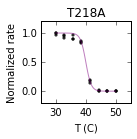

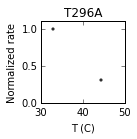

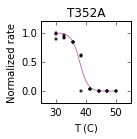

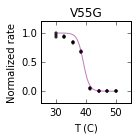

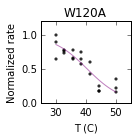

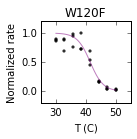

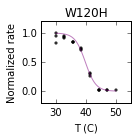

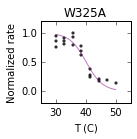

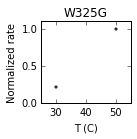

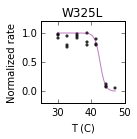

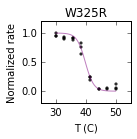

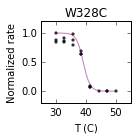

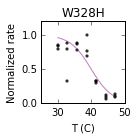

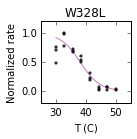

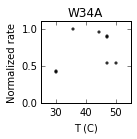

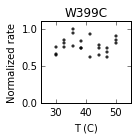

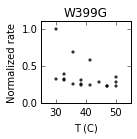

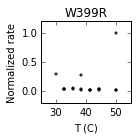

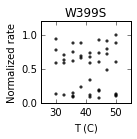

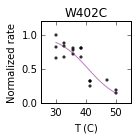

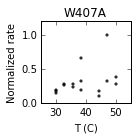

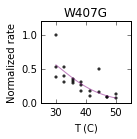

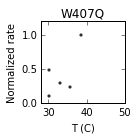

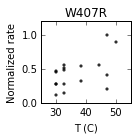

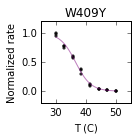

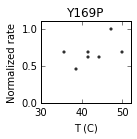

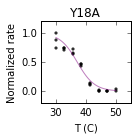

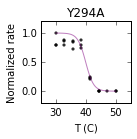

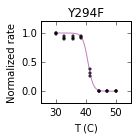

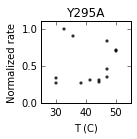

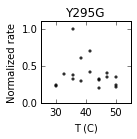

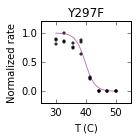

In [269]:
#!mkdir plots 
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() 
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    plt.show()
    plt.close()

In [270]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
W328H,39.944934,-0.320261,W,H,328
E222Q,39.421645,-0.815422,E,Q,222
S14A,40.017869,-1.565036,S,A,14
E222H,34.708312,-0.636223,E,H,222
H178A,34.903381,-0.272210,H,A,178
N293C,38.667392,-0.536787,N,C,293
W34A,NaN,NaN,W,A,34
N354A,40.557793,-0.335794,N,A,354
W325G,NaN,NaN,W,G,325


In [271]:
# makes resfiles for DDG Rosetta app 
#!mkdir ddg/resfiles 

for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

In [272]:
%%bash 
# this will run the Rosetta app `ddg_monomer` on all the mutants in `fits`, above

#ls ddg/resfiles > ddg/list
#NUM=$( wc -l ddg/list | cut -d' ' -f1 )
#cd ddg && sbatch --array=1-${NUM} sub.sh 

## Comparison between Rosetta `ddg_monomer` app and experimental results

In [273]:
! ( head -1 ddg/ddg_predictions.out && grep -v desc ddg/ddg_predictions.out ) > ddg/readable_output

In [274]:
preds = pandas.read_csv( 'ddg/readable_output', sep='\s+' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,hbond_sr_bb,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
P329N,ddG:,P329N,3.537,2.321,-0.903,-2.334,-0.019,3.267,-0.124,-0.026,...,-0.535,0.202,-0.723,0,0,30.250264,-0.791904,P,N,329
H178R,ddG:,H178R,3.028,-1.812,-0.298,7.895,0.112,-1.961,0.050,0.417,...,0.825,0.495,-0.507,0,0,NaN,NaN,H,R,178
E222Q,ddG:,E222Q,-3.113,-0.458,-0.951,-0.013,0.040,-4.162,0.046,-0.087,...,3.746,-0.280,0.376,0,0,39.421645,-0.815422,E,Q,222
N293A,ddG:,N293A,0.679,3.090,-1.320,-3.727,0.026,-0.316,0.027,-0.102,...,0.555,0.039,1.535,0,0,44.526541,-0.117798,N,A,293
Y294F,ddG:,Y294F,-2.903,-2.361,0.167,2.006,0.008,-2.086,-0.005,-0.061,...,-0.205,0.036,0.299,0,0,40.764470,-1.145973,Y,F,294
I244E,ddG:,I244E,3.072,-5.597,1.614,9.485,-0.037,1.438,0.031,0.194,...,-0.375,0.490,-2.386,0,0,37.793129,-0.872061,I,E,244
Y294A,ddG:,Y294A,6.140,14.237,-0.620,-5.127,-0.028,-0.701,-0.070,-0.105,...,-2.869,-0.014,0.461,0,0,39.999766,-0.755361,Y,A,294
W399R,ddG:,W399R,10.291,7.418,-0.426,3.687,-0.024,1.043,0.000,0.058,...,0.182,0.301,-1.078,0,0,NaN,NaN,W,R,399
G355A,ddG:,G355A,0.021,-4.166,1.793,1.063,-0.014,-0.736,0.037,0.015,...,-0.219,1.237,0.452,0,0,NaN,NaN,G,A,355
H178A,ddG:,H178A,3.120,12.923,-1.200,-5.726,0.025,-1.762,0.045,0.037,...,-0.401,0.243,0.235,0,0,34.903381,-0.272210,H,A,178


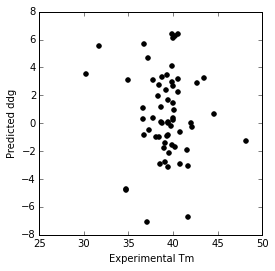

In [275]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
#plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )

total float64


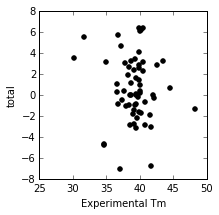

fa_atr float64


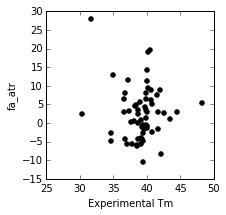

fa_rep float64


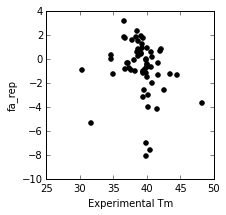

fa_sol float64


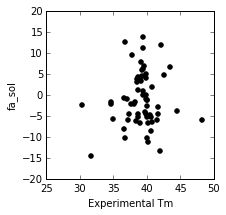

fa_intra_rep float64


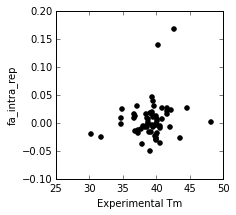

fa_elec float64


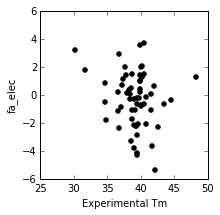

pro_close float64


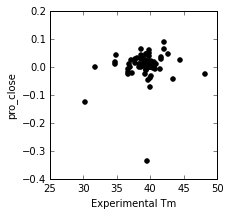

hbond_sr_bb float64


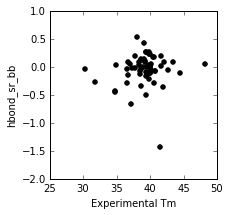

hbond_lr_bb float64


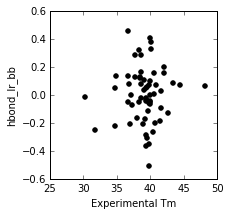

hbond_bb_sc float64


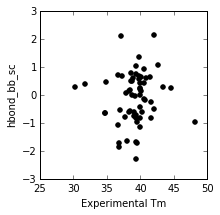

hbond_sc float64


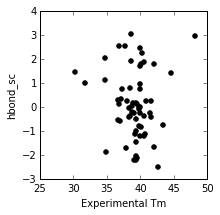

dslf_fa13 float64


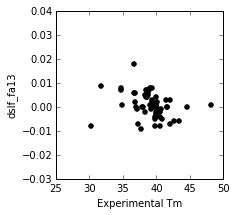

coordinate_constraint float64


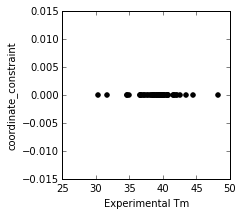

angle_constraint float64


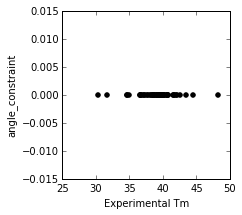

dihedral_constraint float64


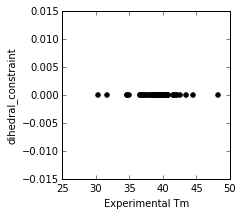

rama float64


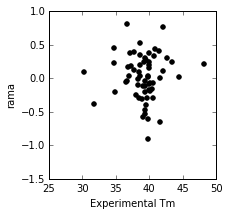

omega float64


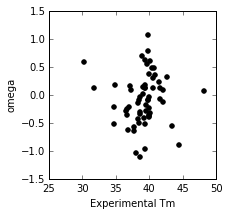

fa_dun float64


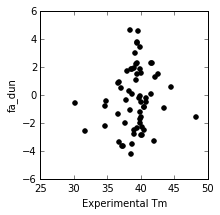

p_aa_pp float64


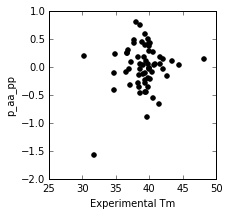

ref float64


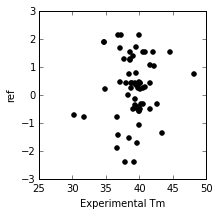

chainbreak float64


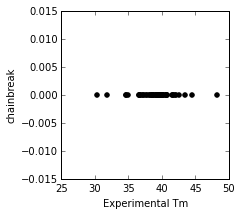

res_type_constraint float64


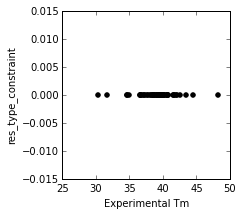

position float64


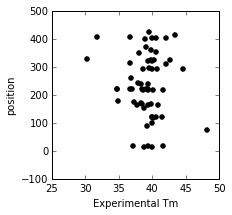

In [276]:
for col, dtype in zip( joined.columns, joined.dtypes ):
    if str( dtype ) == 'float64' and str( col ) not in ['tm', 'k']:
        print col, dtype
        plt.figure( figsize=( 3, 3 ) )
        plt.scatter( joined.tm, joined[col], color='k' )
        #plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
        plt.xlabel( 'Experimental Tm' )
        plt.ylabel( col )
        plt.show()

So nothing really correlates, even predicted $\Delta G$ of folding. Bummmer. 

# Rosetta plus machine learning [outperforms `ddg_monomer`?]

Instead, let's make models of the mutants using `EnzRepackMinimize` and then try to use machine learning to get better correlation.

In [277]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.grid_search import GridSearchCV
from glob import glob 

dfs = [ pandas.read_csv( i, sep=r'\s+' ) for i in glob( 'enzdes/out/*sc' ) ]
df = pandas.concat( dfs )
print len( df ), 'models'
df.sample( 10 )

12863 models


,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description
0,-625.52,227.12,-71.51,0.01,0.69,0.68,145,436,149,0.60,...,446,-5.47,0.83,-3.29,0,-10.95,0.88,7,1,bglb_220ALA_43_0001
0,-626.16,226.21,-72.44,0.01,0.69,0.69,141,439,148,0.67,...,446,-5.77,0.95,-3.92,0,-11.53,0.89,8,1,bglb_171ALA_43_0001
0,-623.72,227.42,-71.81,0.01,0.71,0.69,144,438,150,0.81,...,446,-5.37,0.87,-3.29,0,-10.75,0.90,7,1,bglb_281HIS_88_0001
1,-631.02,224.39,-72.00,0.00,0.70,0.70,149,440,149,0.65,...,446,-5.39,0.87,-3.72,0,-10.79,0.92,8,1,bglb_298GLU_37_0001
0,-628.31,226.81,-72.79,0.00,0.70,0.69,146,439,150,0.99,...,446,-5.16,0.92,-3.36,0,-10.32,0.90,7,1,bglb_119ASN_53_0001
0,-629.91,223.18,-73.19,0.00,0.69,0.68,142,437,148,0.77,...,446,-5.80,0.95,-3.99,0,-11.60,0.91,8,1,bglb_294ALA_8_0001
0,-625.85,226.25,-72.92,0.00,0.71,0.71,147,440,151,0.65,...,446,-5.94,0.91,-3.91,0,-11.88,0.90,8,1,bglb_171ASP_78_0001
0,-627.50,228.22,-73.62,0.00,0.70,0.69,142,441,151,0.75,...,446,-5.85,0.89,-3.93,0,-11.70,0.91,8,1,bglb_355ALA_75_0001
0,-627.06,225.19,-70.32,0.01,0.69,0.69,143,437,148,0.60,...,446,-5.64,0.93,-3.46,0,-11.27,0.90,7,1,bglb_163ALA_21_0001
0,-624.28,226.34,-70.34,0.00,0.69,0.70,148,440,150,0.75,...,446,-5.09,0.85,-3.07,0,-10.18,0.91,7,1,bglb_154ASP_3_0001


In [278]:
from Bio.SeqUtils import IUPACData
import screed

for record in screed.open( 'data/bglb.pep' ):
    seq = record.sequence

# blarg, we have to reindex the DataFrame because of how I named the Rosetta output
l = []
for i in df.description:
    j = i.split( '_' )[1]
    pos = j[:-3]
    native = seq[ int(pos) - 1 ].upper()
    designed = IUPACData.protein_letters_3to1[ j[-3:].capitalize() ] # good god why
    l.append( '{}{}{}'.format( native, pos, designed ) )
df['name'] = l

In [279]:
# get lowest 10% energy by total_score 
def low_10( df ):
    return df.sort( 'total_score' ).head( 10 )

df = df.groupby( 'name' ).head( 10 )
df

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_total_score,SR_5_fa_rep,SR_5_hbond_sc,SR_5_all_cst,SR_5_interf_E_1_2,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description,name
0,-621.52,227.68,-71.56,0.01,0.70,0.68,145,438,150,0.67,...,-5.45,0.95,-3.62,0.00,-10.91,0.90,8,1,bglb_219ALA_98_0001,L219A
0,-625.44,223.92,-74.89,0.01,0.69,0.69,140,439,148,0.67,...,-6.42,0.77,-4.23,0.00,-12.84,0.91,8,1,bglb_34ALA_59_0001,W34A
0,-623.50,227.11,-71.43,0.00,0.71,0.69,148,437,150,0.99,...,-5.75,0.89,-4.01,0.00,-11.49,0.93,8,1,bglb_240LYS_15_0001,R240K
0,-612.03,225.36,-66.07,0.00,0.70,0.68,148,433,146,0.99,...,-3.54,1.09,-1.78,0.00,-7.08,0.91,4,2,bglb_407ALA_62_0001,W407A
0,-620.22,226.81,-69.18,0.00,0.69,0.69,149,435,147,0.65,...,-5.06,0.85,-3.14,0.00,-10.12,0.91,7,1,bglb_407TYR_24_0001,W407Y
0,-626.34,225.29,-73.66,0.01,0.68,0.67,144,439,147,0.65,...,-5.93,0.89,-4.03,0.00,-11.85,0.90,8,1,bglb_72ALA_49_0001,F72A
0,-630.24,225.53,-73.43,0.00,0.71,0.70,137,440,149,0.72,...,-5.96,0.93,-3.98,0.00,-11.92,0.90,8,1,bglb_404ALA_44_0001,N404A
0,-630.54,225.68,-74.10,0.01,0.70,0.70,141,439,151,0.77,...,-5.96,0.92,-4.07,0.01,-11.92,0.91,8,1,bglb_52GLY_55_0001,V52G
0,-629.84,224.86,-72.00,0.01,0.71,0.70,143,439,149,0.75,...,-5.18,1.09,-3.47,0.00,-10.36,0.90,7,1,bglb_315ASN_66_0001,H315N
0,-555.96,277.82,-70.43,0.00,0.70,0.69,154,433,143,0.77,...,-5.70,1.12,-3.98,0.00,-11.41,0.90,8,1,bglb_32LEU_100_0001,S32L


In [280]:
# reindex and join with experimental data 
df.index = df.name 
joined = df.join( fits )
joined.sample( 10 )

,total_score,fa_rep,hbond_sc,all_cst,tot_pstat_pm,tot_nlpstat_pm,tot_burunsat_pm,tot_hbond_pm,tot_NLconts_pm,tot_nlsurfaceE_pm,...,SR_5_dsasa_1_2,SR_5_hbond_pm,SR_5_burunsat_pm,description,name,tm,k,native,designed,position
R76A,-631.13,223.72,-67.92,0.00,0.68,0.69,139,434,148,0.77,...,0.90,7,1,bglb_76ALA_32_0001,R76A,48.214252,-0.068753,R,A,76
H178A,-629.02,225.29,-73.29,0.01,0.67,0.68,145,438,151,0.77,...,0.89,8,1,bglb_178ALA_73_0001,H178A,34.903381,-0.272210,H,A,178
E222K,-632.74,223.28,-72.49,0.00,0.68,0.68,151,438,147,0.77,...,0.96,9,1,bglb_222LYS_89_0001,E222K,38.526868,-0.464967,E,K,222
E388C,-628.04,225.83,-71.03,0.01,0.70,0.69,142,436,149,0.94,...,0.90,7,1,bglb_388CYS_14_0001,E388C,NaN,NaN,NaN,NaN,NaN
I244N,-624.83,226.32,-71.83,0.01,0.68,0.68,148,438,150,0.77,...,0.91,7,1,bglb_244ASN_35_0001,I244N,NaN,NaN,NaN,NaN,NaN
L171D,-633.03,224.22,-73.28,0.00,0.69,0.69,145,441,149,0.82,...,0.89,8,1,bglb_171ASP_82_0001,L171D,NaN,NaN,NaN,NaN,NaN
V320Q,-633.81,224.27,-73.11,0.00,0.70,0.69,144,438,151,0.75,...,0.90,8,1,bglb_320GLN_33_0001,V320Q,NaN,NaN,NaN,NaN,NaN
F405A,-628.81,224.97,-74.07,0.00,0.70,0.68,139,441,150,0.60,...,0.90,8,1,bglb_405ALA_43_0001,F405A,NaN,NaN,NaN,NaN,NaN
R240D,-624.91,225.09,-71.14,0.00,0.69,0.69,149,436,152,0.67,...,0.93,8,1,bglb_240ASP_53_0001,R240D,NaN,NaN,R,D,240
W407R,-624.79,224.58,-73.04,0.00,0.70,0.69,147,437,150,0.65,...,0.91,7,1,bglb_407ARG_41_0001,W407R,NaN,NaN,W,R,407


In [281]:
# diagnostics and droping NaN values 
print len( joined )
joined.dropna( inplace = True )
print len( joined ), 'models'

# clean up data for sklearn
x_cols = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', ]

X = joined[ x_cols ]
y = joined[ 'tm' ]

1250
490 models


Now we actually fit the data to the model

Number of models 1
PCC=(0.63353721247046713, 2.4054607326736371e-56)


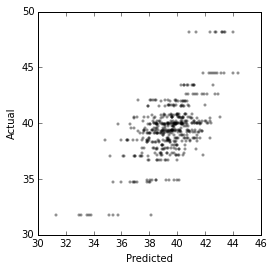

             feature    weight
14       SR_1_fa_rep -5.207923
21       SR_2_fa_rep -2.876031
39  SR_4_burunsat_pm -1.329307
40     SR_4_pstat_pm -1.290754
44     SR_5_hbond_sc -1.206539
41   SR_4_nlpstat_pm -0.837132
5    tot_burunsat_pm -0.279584
27   SR_2_nlpstat_pm -0.255490
36       SR_4_fa_rep -0.177057
28  SR_3_total_score -0.162641
24     SR_2_hbond_pm -0.127844
Number of models 10
PCC=(0.64827108444521386, 9.4252903260287976e-60)


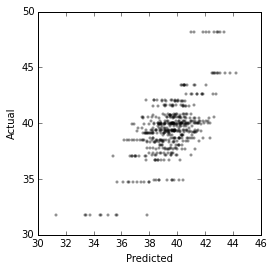

             feature    weight
14       SR_1_fa_rep -5.466466
21       SR_2_fa_rep -2.937207
44     SR_5_hbond_sc -0.961595
24     SR_2_hbond_pm -0.958914
41   SR_4_nlpstat_pm -0.797712
39  SR_4_burunsat_pm -0.699361
36       SR_4_fa_rep -0.447861
5    tot_burunsat_pm -0.300326
26     SR_2_pstat_pm -0.298574
40     SR_4_pstat_pm -0.129565
9   tot_total_charge -0.124312
Number of models 100
PCC=(0.65084074841262751, 2.2942789646694312e-60)


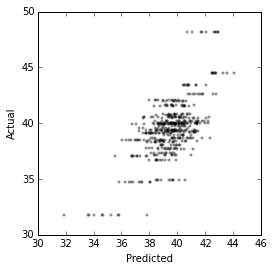

             feature    weight
14       SR_1_fa_rep -5.789405
21       SR_2_fa_rep -4.397414
44     SR_5_hbond_sc -2.726208
39  SR_4_burunsat_pm -1.635863
24     SR_2_hbond_pm -0.279680
5    tot_burunsat_pm -0.118650
9   tot_total_charge -0.101624
0        total_score -0.011904
29       SR_3_fa_rep -0.005786
28  SR_3_total_score  0.000000
47    SR_5_dsasa_1_2  0.000000
Number of models 1000
PCC=(0.65286044519142605, 7.4839812706991943e-61)


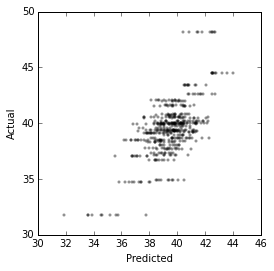

             feature    weight
14       SR_1_fa_rep -5.670387
21       SR_2_fa_rep -5.432572
44     SR_5_hbond_sc -3.511072
39  SR_4_burunsat_pm -1.952033
41   SR_4_nlpstat_pm -1.845336
40     SR_4_pstat_pm -0.547331
9   tot_total_charge -0.361346
5    tot_burunsat_pm -0.233601
24     SR_2_hbond_pm -0.232004
29       SR_3_fa_rep -0.026717
0        total_score -0.011787


In [282]:
params = { 'l1_ratio': [.1, .5, .7, .9, .95, .99, 1] }

from sklearn.cross_validation import StratifiedKFold
from scipy.stats.stats import pearsonr

for i in [ 1, 10, 100, 1000 ]:
    #skf = StratifiedKFold( y, 10 )
    net = ElasticNetCV( cv=10 )
    grid = GridSearchCV( net, params )
    bag = BaggingRegressor( grid, n_estimators=i )
    bag.fit( X, y )

    preds = bag.predict( X )
    print 'Number of models', i 
    print 'PCC={}'.format( pearsonr( preds, y ) )

    plt.figure( figsize=(4,4) )
    plt.scatter( preds, y, alpha=0.3, marker='.', color='k' )
    plt.xlabel( 'Predicted' )
    plt.ylabel( 'Actual' )
    plt.show()
    
    weights = pandas.DataFrame( zip( X.columns, bag.estimators_[0].best_estimator_.coef_ ), columns=['feature', 'weight'] )
    print weights.sort( 'weight' )[0:11]